# Exploring Stable Diffusion

This code is based on Stable Diffusion Deep Dive notebook by @johnowhitaker 

#| hide
## Setup

#### Imports

In [1]:
#| hide
import torch
from torch import autocast
from transformers import CLIPModel, CLIPVisionModel, CLIPProcessor
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms
from fastdownload import FastDownload

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()


/home/fredguth/.miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/fredguth/.miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#| hide
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu";torch_device

'cuda'

#### Loading the models

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
# The CLIP Model for generating the embeddings
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
tokenizer = processor.tokenizer
# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = model.text_model.to(torch_device)
image_encoder = model.vision_model.to(torch_device)
unet = unet.to(torch_device)

#### Some settings

In [4]:
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
scheduler.set_timesteps(num_inference_steps)

#### Utility functions

In [5]:
def generate_seed_latent():
    # Prep latents
    latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8), generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma 
    return latents

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

# denoising loop
def sdloop(latents, hidden):
    with autocast("cuda"):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            sigma = scheduler.sigmas[i]
            # Scale the latents (preconditioning):
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)
            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=hidden).sample
            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
            latents = scheduler.step(noise_pred, t, latents).prev_sample
    # scale and decode the image latents with vae
#     latents = 1 / 0.18215 * latents
    return latents

## Exploring CLIP embeddings

First, let's simplify the unconditioning embedding code.
From `Stable Diffusion Deep Dive` notebook, we have:

In [6]:
# Prep text 
prompt = ["A watercolor painting of an otter"]
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]; max_length
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings]).half()
text_embeddings.shape

torch.Size([2, 77, 768])

0it [00:00, ?it/s]

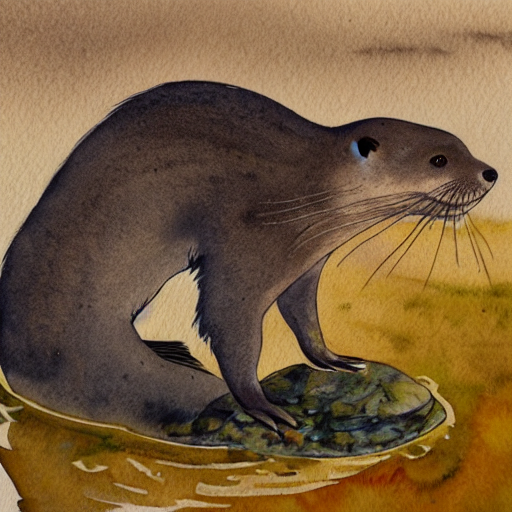

In [7]:
latents = sdloop(generate_seed_latent(), text_embeddings)
latents_to_pil(latents.to(torch.float32))[0]

but we could simplify this with:

In [8]:
prompts = ["", "A watercolor painting of an otter"]
inputs = processor(text=prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    t_e = text_encoder(input_ids=inputs.input_ids.to(torch_device))[0].half()
t_e.shape

torch.Size([2, 77, 768])

0it [00:00, ?it/s]

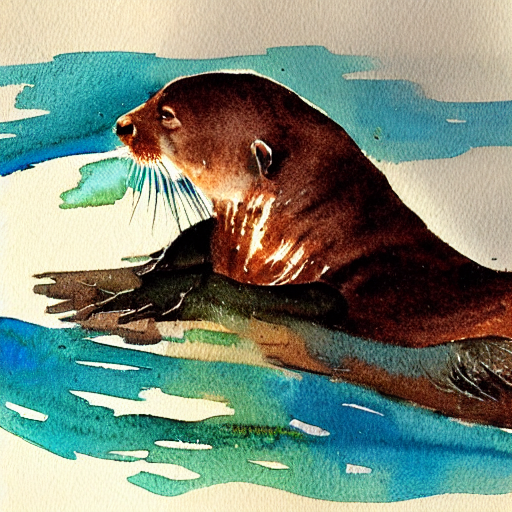

In [9]:
latents = sdloop(generate_seed_latent(), t_e)
otter = latents_to_pil(latents.to(torch.float32))[0];otter

Notice also that:

In [10]:
text_encoder(input_ids=inputs.input_ids.to(torch_device))

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [-0.2279,  0.0401,  1.4532,  ..., -0.8664, -0.0721,  1.8452],
         ...,
         [ 0.4580,  0.4419,  1.0750,  ..., -1.6370, -1.5812, -0.2933],
         [ 0.4597,  0.4174,  1.0474,  ..., -1.6088, -1.5758, -0.2907],
         [ 0.4342,  0.4253,  1.1790,  ..., -1.6748, -1.5393, -0.3574]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_out

i.e. the encoder returns not only 2 vectors representing the 2 prompts in the input:

In [11]:
text_encoder(input_ids=inputs.input_ids.to(torch_device))[1].shape

torch.Size([2, 768])

but also the `last_hidden_state`, i.e the layer that will produce this embedding. This `layer` is what is added to the `unet`  and conditions the image generation to produce something simillar to the embedding. 

In [12]:
text_encoder(input_ids=inputs.input_ids.to(torch_device))[0].shape

torch.Size([2, 77, 768])

This weights will be frozen in the `unet`. 

### Image embeddings

Another interesting point of the `processor` is that it can generate image embeddings as well. Let us look at it.

In [13]:
images = [otter]
inputs = processor(text=prompts, images=images, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    t_e = text_encoder(input_ids=inputs.input_ids.to(torch_device))[0].half()
    i_e = image_encoder(pixel_values=inputs.pixel_values.to(torch_device))[0].half()
t_e.shape,  i_e.shape

(torch.Size([2, 77, 768]), torch.Size([1, 257, 1024]))

For some reason, vision_model.embeddings and text_model.embeddings are not the directly comparable

In [14]:
text_encoder.embeddings, image_encoder.embeddings

(CLIPTextEmbeddings(
   (token_embedding): Embedding(49408, 768)
   (position_embedding): Embedding(77, 768)
 ),
 CLIPVisionEmbeddings(
   (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
   (position_embedding): Embedding(257, 1024)
 ))

###  Comparing Image and Text embeddings

We need to project these embeddings to the same space to make them comparable

In [27]:
image_projection = model.visual_projection.to(torch_device)
text_projection = model.text_projection.to(torch_device)
prompts = ["", "A watercolor painting of an otter", "A photograph of an astronaut riding a horse"]
inputs = processor(text=prompts,images = images, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")  
with autocast('cuda'):
    with torch.no_grad():
        vision_outputs = image_encoder(pixel_values=inputs.pixel_values.to(torch_device))
        text_outputs = text_encoder(input_ids=inputs.input_ids.to(torch_device))
        img_embeds = image_projection(vision_outputs[1])
        txt_embeds = text_projection(text_outputs[1])
        i_proj = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)
        t_proj = txt_embeds / txt_embeds.norm(p=2, dim=-1, keepdim=True)
i_proj.shape, t_proj.shape

(torch.Size([1, 768]), torch.Size([3, 768]))

In [28]:
# cosine similarity as logits
logits_per_text = torch.matmul(t_proj, i_proj.t()) 
logits_per_image = logits_per_text.t()

In [29]:
probs = logits_per_image.softmax(dim=1);probs

tensor([[0.3257, 0.3914, 0.2829]], device='cuda:0')

The image is more similar to the second prompt: "A watercolor painting of an otter".
Still, I expected a bigger difference among the prompts probabilities.

## Conditioning with Image Embeddings

Unfortunately, the `unet` only works with the text_encoder hidden states dimensions:

In [18]:
t_e.shape

torch.Size([2, 77, 768])

In [19]:
latents = generate_seed_latent()
latent_model_input = torch.cat([latents] * 2)
with torch.no_grad():
    with autocast('cuda'):
        npred = unet(latent_model_input, scheduler.timesteps[15], encoder_hidden_states=t_e).sample
npred.shape

torch.Size([2, 4, 64, 64])

In [20]:
latent_model_input = torch.cat([latents] * 2)
with torch.no_grad():
    with autocast('cuda'):
        npred = unet(latent_model_input, scheduler.timesteps[15], encoder_hidden_states=i_e).sample
npred.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (257x1024 and 768x320)